In [1]:
import csv
import random
import pandas as pd
from tqdm import tqdm
from itertools import islice
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

SEED = 1337
random.seed(SEED)

INFO 03-16 01:35:07 __init__.py:190] Automatically detected platform cuda.


In [2]:
df = pd.read_csv("../../data/data_raw/reddit.csv")
df.head()

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [3]:
df.isna().sum()

subreddit           0
body                0
controversiality    0
score               0
dtype: int64

In [4]:
df["body_length"] = df["body"].str.len()

In [5]:
df = df[df["body_length"] >= 50]
df = df[df["subreddit"] != "Pikabu"]
df

,subreddit,body,controversiality,score,body_length
0,gameofthrones,Your submission has been automatically removed...,0,1,545
1,aww,"Dont squeeze her with you massive hand, you me...",0,19,55
2,gaming,It's pretty well known and it was a paid produ...,0,3,390
3,news,You know we have laws against that currently c...,0,10,111
4,politics,"Yes, there is a difference between gentle supp...",0,1,101
...,...,...,...,...,...
999867,trashy,I'm a mostly heartless asshole &amp; that stil...,0,2,68
999870,trashy,LOL. He also said something about turning them...,0,1,180
999871,trashy,Yeah I love helping and being close to my fami...,0,1,255
999876,trashy,As a Canadian lefty I have to say I find Ameri...,0,11,277


In [6]:
df.duplicated(subset="body").sum()

np.int64(22065)

In [7]:
df.drop_duplicates(subset="body", inplace=True)
df.reset_index(drop=True)

,subreddit,body,controversiality,score,body_length
0,gameofthrones,Your submission has been automatically removed...,0,1,545
1,aww,"Dont squeeze her with you massive hand, you me...",0,19,55
2,gaming,It's pretty well known and it was a paid produ...,0,3,390
3,news,You know we have laws against that currently c...,0,10,111
4,politics,"Yes, there is a difference between gentle supp...",0,1,101
...,...,...,...,...,...
655480,trashy,I'm a mostly heartless asshole &amp; that stil...,0,2,68
655481,trashy,LOL. He also said something about turning them...,0,1,180
655482,trashy,Yeah I love helping and being close to my fami...,0,1,255
655483,trashy,As a Canadian lefty I have to say I find Ameri...,0,11,277


In [8]:
len(df)

655485

In [9]:
def batchify(iterable, batch_size):
    """Splits an iterable into smaller batches."""
    iterable = iter(iterable)
    while batch := list(islice(iterable, batch_size)):
        yield batch

def save_to_csv(path, prompts, responses, temperature, top_p, top_k):
    """Saves prompts, responses and sampling parameters to a CSV file."""
    with open(path, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for prompt, response in zip(prompts, responses):
            writer.writerow([prompt, response, temperature, top_p, top_k])

def generate_responses(model, prompts, sampling_params):
    """Generate a batch of outputs using vLLM with customizable sampling parameters."""
    outputs = model.chat(prompts, sampling_params=sampling_params, use_tqdm=False)
    
    return [sample.outputs[0].text.replace('"', '') for sample in outputs]

In [10]:
BASE_PROMPT = [{"role": "system", "content": "You are a helpful asistant for rewritting reddit comments. Based on provided comment and subreddit name, on which the comment was posted, generate a similar one. MAKE SURE TO REPLAY ONLY WITH THE SIMILAR COMMENT."},
                {"role": "user", "content": "Comment: \n {comment} \n Subreddit: {subreddit}"},
                {"role": "assistant", "content": "Similar comment: \n"}]

In [11]:
prompts = [
    [
        BASE_PROMPT[0],  # The system message
        {"role": "user", "content": BASE_PROMPT[1]["content"].format(comment=comment, subreddit=subreddit)},  # Formatted user message
        BASE_PROMPT[2]  # The assistant message
    ]
    for comment, subreddit in df[["body", "subreddit"]].values
]

In [12]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

In [13]:
lens = []
batch_size = 128
for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
    tokens = tokenizer.apply_chat_template(prompts_batch)
    lens.extend([len(token) for token in tokens])

  0%|          | 0/5120 [00:00<?, ?it/s]

5121it [03:16, 26.02it/s]                          


In [14]:
too_large = [i for i, l in enumerate(lens) if l > 16_384]
too_large

[391023]

In [16]:
df.drop(["subreddit", "controversiality", "score"], axis=1, inplace=True)
df.to_csv("../../data/data_human/reddit.csv", index=False)

In [17]:
from nltk.tokenize import word_tokenize, sent_tokenize
df['word_count'] = df['body'].apply(lambda x: len(word_tokenize(x)))
df['sentence_count'] = df['body'].apply(lambda x: len(sent_tokenize(x)))

In [18]:
import numpy as np
import matplotlib.ticker as ticker

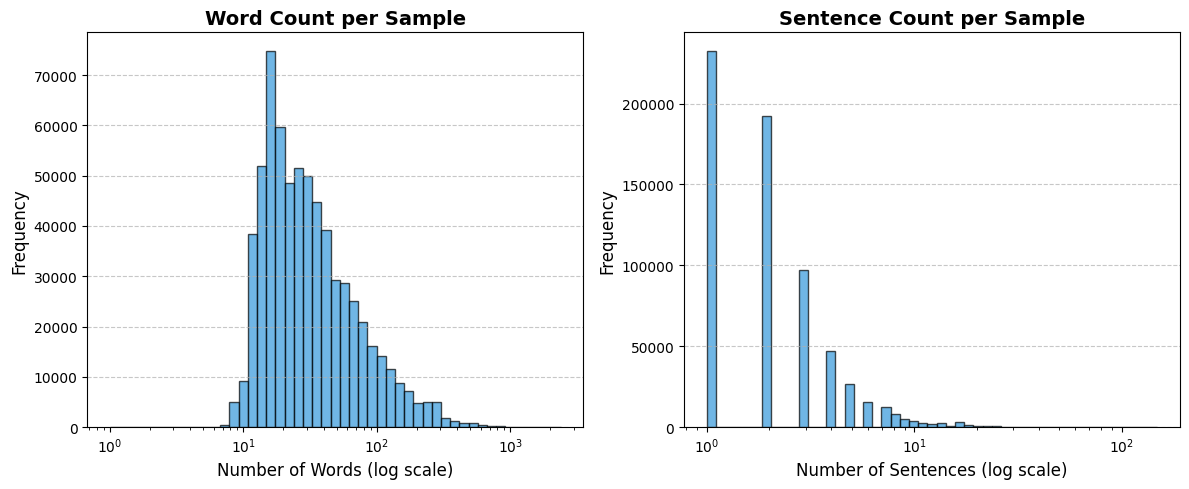

In [19]:
import matplotlib.pyplot as plt
word_bins = np.logspace(np.log10(1), np.log10(df['word_count'].max()), 50)
sentence_bins = np.logspace(np.log10(1), np.log10(df['sentence_count'].max()), 50)

# Plot histograms using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Word count histogram
axes[0].hist(df['word_count'], bins=word_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xscale('log')  # Logarithmic scale for x-axis
axes[0].set_title('Word Count per Sample', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Words (log scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].tick_params(axis='both', which='minor', labelsize=8)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sentence count histogram
axes[1].hist(df['sentence_count'], bins=sentence_bins, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xscale('log')  # Logarithmic scale for x-axis
axes[1].set_title('Sentence Count per Sample', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Sentences (log scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].tick_params(axis='both', which='minor', labelsize=8)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
sampling_params = [
    SamplingParams(temperature=0.0, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Pure Greedy (fully deterministic)
    SamplingParams(temperature=0.2, top_p=1.0, top_k=-1, max_tokens=30_000, seed=SEED),  # Highly Deterministic
    SamplingParams(temperature=0.5, top_p=0.95, top_k=100, max_tokens=30_000, seed=SEED), # Mildly Deterministic but Flexible
    SamplingParams(temperature=0.7, top_p=0.9, top_k=50, max_tokens=30_000, seed=SEED),  # Balanced and Natural
    SamplingParams(temperature=0.9, top_p=0.8, top_k=40, max_tokens=30_000, seed=SEED),  # Slightly More Diverse but Coherent
    SamplingParams(temperature=1.0, top_p=0.95, top_k=30, max_tokens=30_000, seed=SEED), # Default Creative Mode
    SamplingParams(temperature=1.2, top_p=0.7, top_k=20, max_tokens=30_000, seed=SEED),  # Highly Creative
]

In [9]:
llms = ["meta-llama/Llama-3.2-1B-Instruct"]
batch_size = 8
base_path = "../../data/data_ai/reddit/reddit_"

In [ ]:
for llm, quant in llms:
    model = LLM(model=llm, dtype="half", max_model_len = 10_000, quantization=quant)
    csv_path = f"{base_path}{llm.split('/')[-1]}.csv"


    # init csv file
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["prompt", "response", "temperature", "top_p", "top_k"])

    cnt = 0
    for prompts_batch in tqdm(batchify(prompts, batch_size), total=len(prompts) // batch_size):
        params = random.choice(sampling_params)
        responses = generate_responses(model, prompts_batch, params)
        save_to_csv(csv_path, prompts_batch, responses, params.temperature, params.top_p, params.top_k)
        cnt += 1
        if cnt > 2:
            break

WARNING 02-15 07:11:42 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-15 07:11:51 config.py:542] This model supports multiple tasks: {'embed', 'generate', 'score', 'reward', 'classify'}. Defaulting to 'generate'.
INFO 02-15 07:11:51 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, c

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-15 07:12:32 model_runner.py:1115] Loading model weights took 2.3185 GB
INFO 02-15 07:12:34 worker.py:267] Memory profiling takes 2.19 seconds
INFO 02-15 07:12:34 worker.py:267] the current vLLM instance can use total_gpu_memory (6.00GiB) x gpu_memory_utilization (0.90) = 5.40GiB
INFO 02-15 07:12:34 worker.py:267] model weights take 2.32GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 1.84GiB.
INFO 02-15 07:12:35 executor_base.py:110] # CUDA blocks: 3761, # CPU blocks: 8192
INFO 02-15 07:12:35 executor_base.py:115] Maximum concurrency for 10000 tokens per request: 6.02x
INFO 02-15 07:12:39 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:30<00:00,  1.16it/s]

INFO 02-15 07:13:10 model_runner.py:1562] Graph capturing finished in 30 secs, took 0.12 GiB
INFO 02-15 07:13:10 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 37.99 seconds



  0%|          | 0/125000 [00:00<?, ?it/s]

INFO 02-15 07:13:10 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


  0%|          | 2/125000 [00:05<91:42:54,  2.64s/it]


In [11]:
df = pd.read_csv("../../data/data_ai/reddit/reddit_Llama-3.2-1B-Instruct.csv")
df.head()

,prompt,response,temperature,top_p,top_k
0,"[{'role': 'system', 'content': 'You are a help...",*This is a major plot twist that completely ch...,1.2,0.7,20
1,"[{'role': 'system', 'content': 'You are a help...","Don't squeeze her with your giant hand, you me...",1.2,0.7,20
2,"[{'role': 'system', 'content': 'You are a help...",It's no surprise that gaming influencers and b...,1.2,0.7,20
3,"[{'role': 'system', 'content': 'You are a help...",You're referring to the 1994 Assault Weapons B...,1.2,0.7,20
4,"[{'role': 'system', 'content': 'You are a help...","Yes, there's a difference between a nuanced ap...",1.2,0.7,20
